In [1]:
# Do this first. It's going to take a while
!pip install pyspark
from pyspark.sql import SparkSession

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=60f17c357aab32c5cbf2ed1f19200a80e98df488da5c1b7906bab9863c1497ba
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
spark = SparkSession.builder.appName("Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()
df = spark.read.csv('socialmedia.csv',header=True,escape="\"")
df.show(10,0)

+------------------+---+------+-----------------+------------------+-----------+----------------+-----------------------------------------------------------------+---------------------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+
|Timestamp         |Age|Gender|Relationship     |Occupation        |Affiliation|Social_Media_Use|Platforms_Used                                                   |Time_on_SM           |SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|
+------------------+---+------+-----------------+------------------+-----------+----------------+-----------------------------------------------------------------+---------

In [3]:
from pyspark.sql.functions import col, isnan, when, count

# Count null values for each column
df.select([count(when(col(c).isNull(), c)).alias(c)
           for c in df.columns]).show()

# drop null values
df = df.dropna()

+---------+---+------+------------+----------+-----------+----------------+--------------+----------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+
|Timestamp|Age|Gender|Relationship|Occupation|Affiliation|Social_Media_Use|Platforms_Used|Time_on_SM|SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|
+---------+---+------+------------+----------+-----------+----------------+--------------+----------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+
|        0

In [4]:
from pyspark.sql.functions import col

# Filter rows containing 'Facebook' in the 'Social_Media_Use' column
df1 = df.filter(col("Platforms_Used").like("%Facebook%") & (df.Social_Media_Use == "Yes"))

# Display the filtered rows
df1.show()

+------------------+---+------+-----------------+------------------+------------------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+
|         Timestamp|Age|Gender|     Relationship|        Occupation|       Affiliation|Social_Media_Use|      Platforms_Used|          Time_on_SM|SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|
+------------------+---+------+-----------------+------------------+------------------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------------+-----------+----------------

In [5]:
from pyspark.sql.functions import when, col

df1 = df1.withColumn(
    "AgeGroup",
    when(col("Age").between(13, 18), "Adolescents (13-18)")
    .when(col("Age").between(19, 29), "Young Adults (19-29)")
    .when(col("Age").between(30, 39), "Adults (30-39)")
    .when(col("Age").between(40, 49), "Middle-Aged Adults (40-49)")
    .when(col("Age").between(50, 100), "Older Adults (over 50)")
)

df1.show()

+------------------+---+------+-----------------+------------------+------------------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+-----------------+-----------+------------------------+--------------------+-------------------+------------------+--------------------+--------------------+------------+--------------------+
|         Timestamp|Age|Gender|     Relationship|        Occupation|       Affiliation|Social_Media_Use|      Platforms_Used|          Time_on_SM|SM_Without_Purpose|SM_Distraction|Restlessness_Without_SM|Easily_Distracted|Worry_Level|Concentration_Difficulty|Comparison_Frequency|Comparison_Feelings|Validation_Seeking|Depression_Frequency|Interest_Fluctuation|Sleep_Issues|            AgeGroup|
+------------------+---+------+-----------------+------------------+------------------+----------------+--------------------+--------------------+------------------+--------------+-----------------------+----

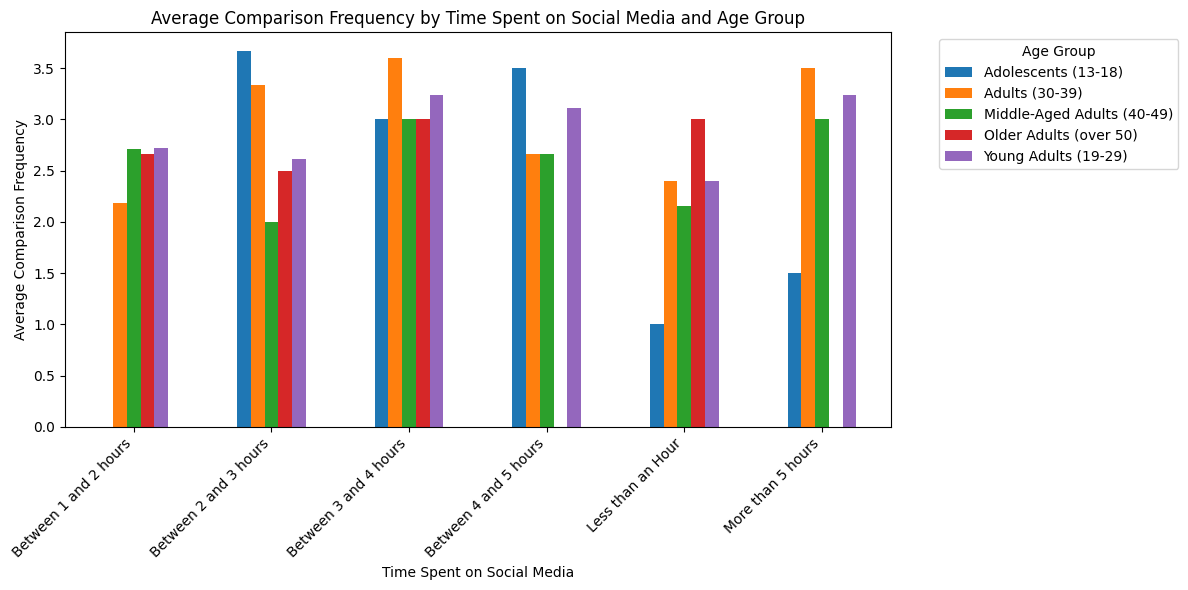

In [8]:
# prompt: average comparison frequency by time_on_sm and agegroup

import matplotlib.pyplot as plt
# Group by 'Time_on_Social_Media' and 'AgeGroup', then calculate the average 'Comparison_Frequency'
time_age_vs_comparison = df1.withColumn('Comparison_Frequency', col('Comparison_Frequency').cast('float')) \
                            .groupBy('Time_on_SM', 'AgeGroup').avg('Comparison_Frequency').toPandas()

# Pivot the table for plotting
time_age_vs_comparison_pivot = time_age_vs_comparison.pivot(index='Time_on_SM', columns='AgeGroup', values='avg(Comparison_Frequency)')

# Plot the grouped bar chart
time_age_vs_comparison_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Average Comparison Frequency by Time Spent on Social Media and Age Group')
plt.xlabel('Time Spent on Social Media')
plt.ylabel('Average Comparison Frequency')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


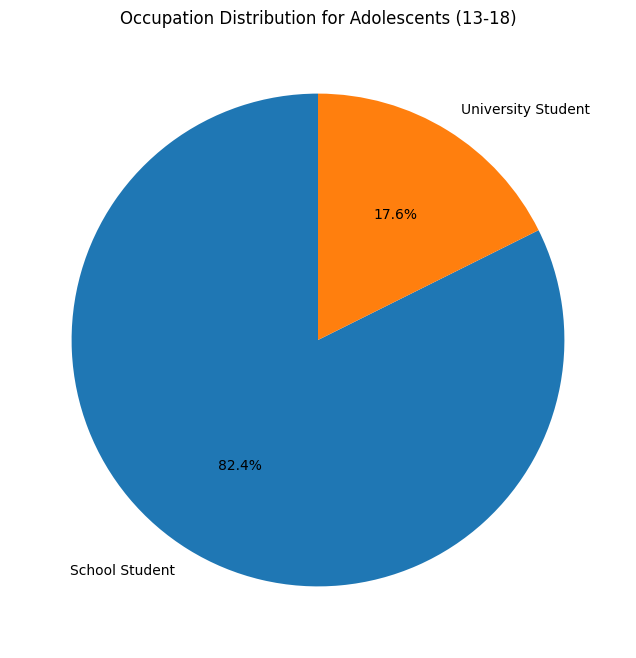

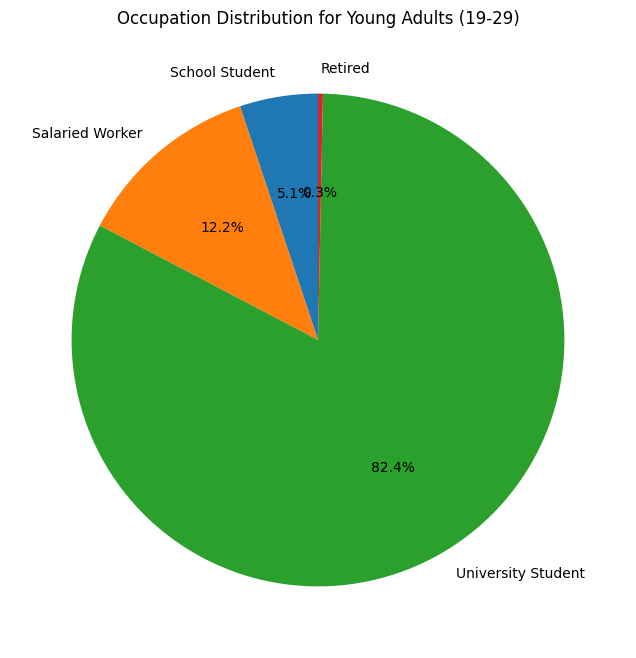

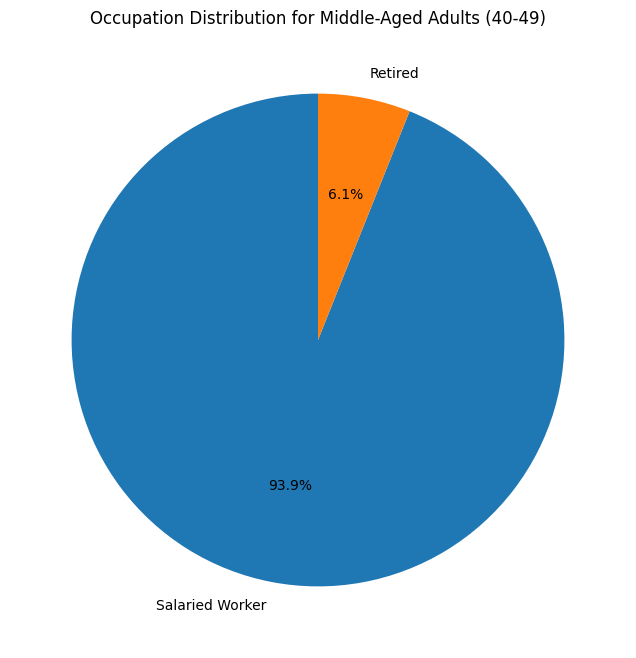

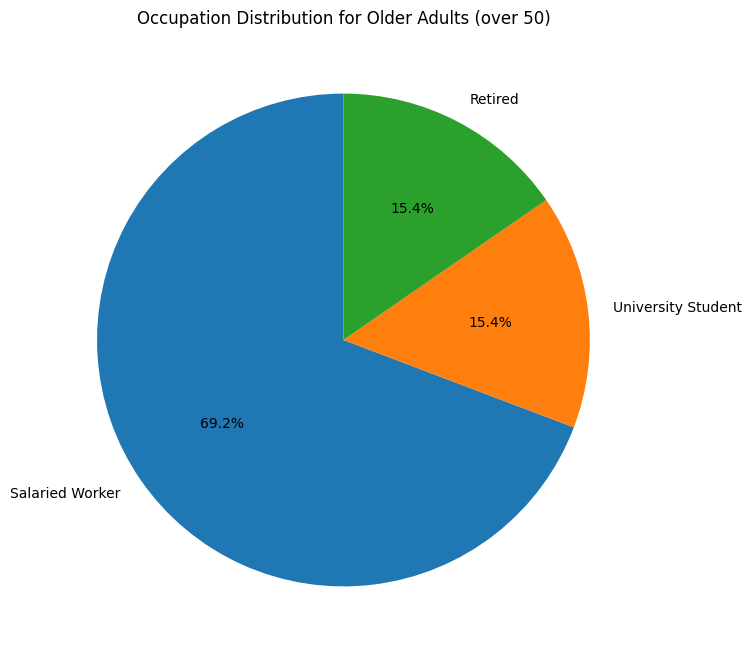

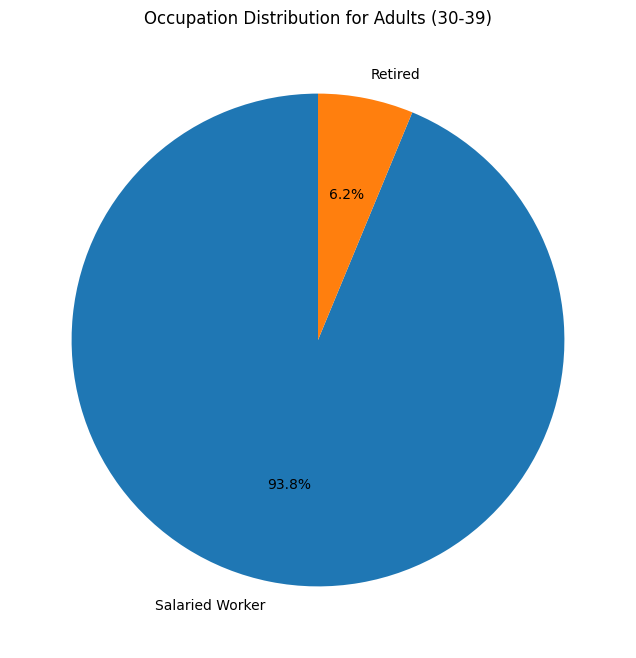

In [50]:
# prompt: pie chart Occupation in AgeGroup

import matplotlib.pyplot as plt
# Group by 'AgeGroup' and 'Occupation', count occurrences
occupation_by_age_group = df1.groupBy('AgeGroup', 'Occupation').count().toPandas()

# Iterate through age groups and create pie charts
for age_group in occupation_by_age_group['AgeGroup'].unique():
    # Filter data for the current age group
    age_group_data = occupation_by_age_group[occupation_by_age_group['AgeGroup'] == age_group]

    # Create pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(age_group_data['count'], labels=age_group_data['Occupation'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Occupation Distribution for {age_group}')
    plt.show()


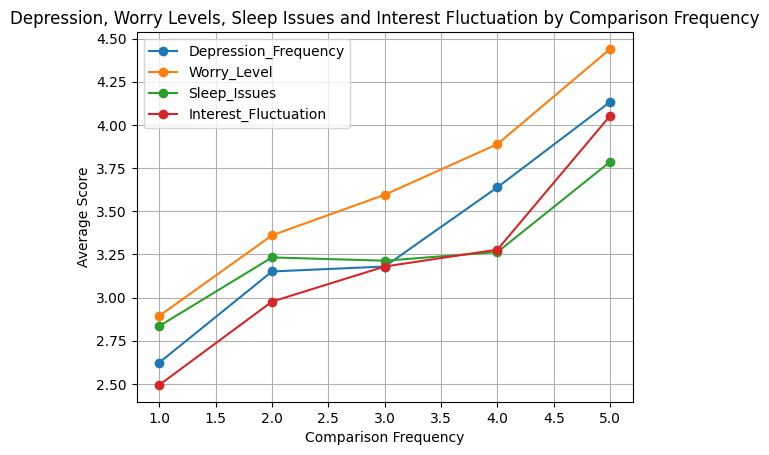

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df1.toPandas()

# Convert 'Depression_Frequency', 'Worry_Level' and 'Comparison_Frequency' to numeric, handling errors
pandas_df['Depression_Frequency'] = pd.to_numeric(pandas_df['Depression_Frequency'], errors='coerce')
pandas_df['Worry_Level'] = pd.to_numeric(pandas_df['Worry_Level'], errors='coerce')
pandas_df['Sleep_Issues'] = pd.to_numeric(pandas_df['Sleep_Issues'], errors='coerce')
pandas_df['Interest_Fluctuation'] = pd.to_numeric(pandas_df['Interest_Fluctuation'], errors='coerce')
pandas_df['Comparison_Frequency'] = pd.to_numeric(pandas_df['Comparison_Frequency'], errors='coerce') # Ensure this column is also numeric for grouping

# Group the Pandas DataFrame by 'Comparison_Frequency' and calculate the mean of 'Depression_Frequency' and 'Worry_Level'
grouped = pandas_df.groupby('Comparison_Frequency')[['Depression_Frequency', 'Worry_Level', 'Sleep_Issues', 'Interest_Fluctuation']].mean()

# Plot the line graph
grouped.plot(kind='line', marker='o')
plt.title('Depression, Worry Levels, Sleep Issues and Interest Fluctuation by Comparison Frequency')
plt.xlabel('Comparison Frequency')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

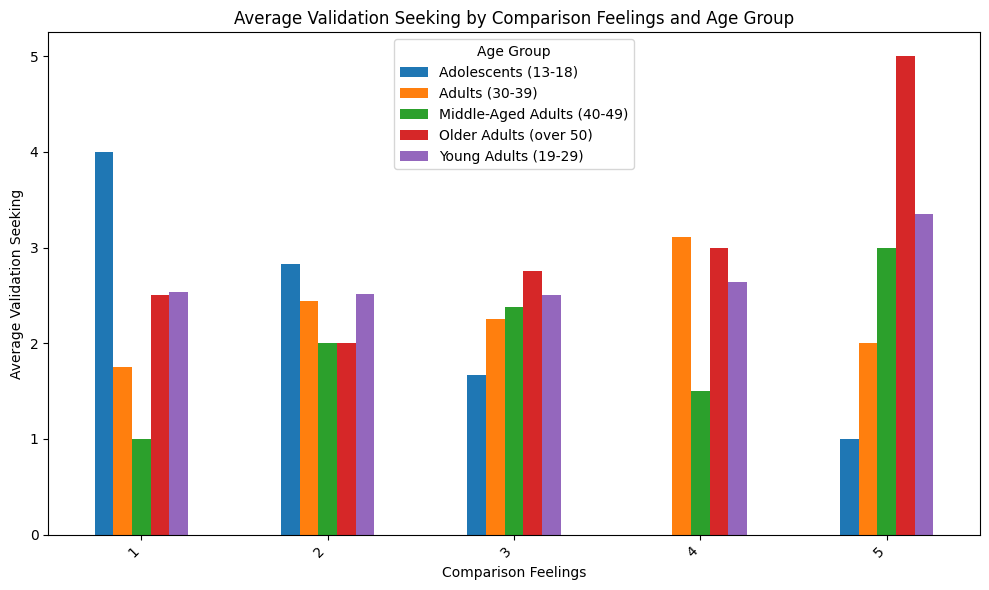

In [60]:
# prompt: validation_seeking based on comparison_feelings and age group

import pandas as pd
import matplotlib.pyplot as plt
# Group the Pandas DataFrame by 'Comparison_Feelings' and 'AgeGroup',
# then calculate the mean of 'Validation_Seeking'
grouped = pandas_df.groupby(['Comparison_Feelings', 'AgeGroup'])['Validation_Seeking'].apply(lambda x: pd.to_numeric(x, errors='coerce').mean()).unstack()

# Plot the grouped bar chart
grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Average Validation Seeking by Comparison Feelings and Age Group')
plt.xlabel('Comparison Feelings')
plt.ylabel('Average Validation Seeking')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()
